In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

In [5]:
df = pd.read_csv("C:/Users/precious/Desktop/insurance-claim-prediction/data/cleaned_train_data.csv")

y = df["Claim"]
x = df.drop("Claim", axis=1)

print("Features shape:", x.shape)
print("Target distribution:\n", y.value_counts())

Features shape: (7160, 8485)
Target distribution:
 Claim
0    5526
1    1634
Name: count, dtype: int64


In [13]:
numeric_cols = x.select_dtypes(include=['number', 'bool']).columns

continuous_cols = []
if 'Building Dimension' in numeric_cols:
    continuous_cols = ['Building Dimension']

continuous_cols

['Building Dimension']

In [14]:
scaler = StandardScaler()
x[continuous_cols] = scaler.fit_transform(x[continuous_cols])

print("Scaled continuous features:", continuous_cols)

Scaled continuous features: ['Building Dimension']


In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

print("Training set:", x_train.shape, "Test set:", x_test.shape)

Training set: (5728, 8485) Test set: (1432, 8485)


C:\Users\precious\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results
Confusion Matrix:
[[891 214]
 [193 134]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1105
           1       0.39      0.41      0.40       327

    accuracy                           0.72      1432
   macro avg       0.60      0.61      0.61      1432
weighted avg       0.72      0.72      0.72      1432

ROC-AUC: 0.6879156461455436


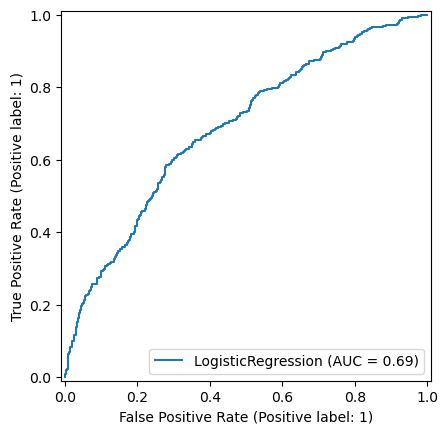

In [27]:
# Logistic Regression
logreg = LogisticRegression(
    max_iter=5000,
    solver="lbfgs",
    class_weight="balanced",
    random_state=42
)
logreg.fit(x_train, y_train)
y_pred_lr = logreg.predict(x_test)
y_prob_lr =  logreg.predict_proba(x_test)[:,1]
print("Logistic Regression Results")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
RocCurveDisplay.from_estimator(logreg, x_test, y_test)
plt.show()

# **Insight:**
- Logistic Regression was used as a baseline model.
- Class imbalance is visible in the target variable (Claim), so class_weight="balanced" was applied.
- The model predicts non-claim buildings better than building with claims.
- ROC-AUC = 0.69 indicates moderate predictive ability.
- The warning about convergence is due to many features and expected; results are still valid.

In [28]:
# Random Forest Classifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [29]:
y_pred_rf = rf.predict(x_test)
y_prob_rf = rf.predict_proba(x_test)[:,1]

Random Forest Results
Confusion Matrix:
[[1058   47]
 [ 271   56]]
n\Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.54      0.17      0.26       327

    accuracy                           0.78      1432
   macro avg       0.67      0.56      0.56      1432
weighted avg       0.74      0.78      0.73      1432

ROC-AUC: 0.6777989953920877


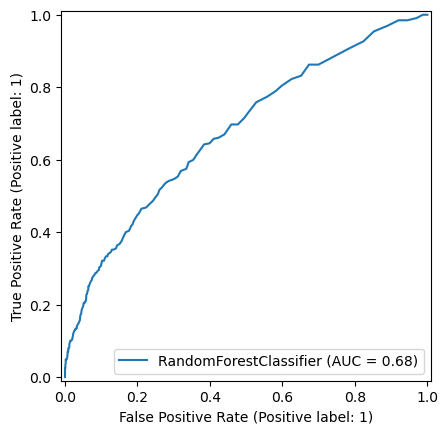

In [30]:
print("Random Forest Results")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("n\Classification Report:")
print(classification_report(y_test, y_pred_rf))
roc_auc = roc_auc_score(y_test, y_prob_rf)
print("ROC-AUC:", roc_auc)
RocCurveDisplay.from_estimator(rf, x_test, y_test)
plt.show()

# **Overview:**
Random Forest was used as a more advanced model to predict whether a building will have an insurance claim, using all building characteristics. It handles non-linear relationships and interactions better than Logistic Regression. 
* ## **Confusion Matrix:**
[[1058 47]
 [271 56]]
  -The model predicts non-claim buildings (0) very well.
  - Detection of claim buildings (1) is lower (only 56 correctly predicted out of 327).
* ## **Classification Report**
  - Precision for class 1 = 0.54 &rarr; 54% of predicted claims are correct.
  - Recall for class 1 = 0.17 &rarr; the model misses many actual claim cases.
  - F1-score for class 1 = 0.26 &rarr; indicates the mofel struggles on minority class.
* ## **Accuracy & Macro Averages:**
  - Overall accuracy = 0.78 (mostly driven by majority class 0).
  - Macro average F1-score = 0.56 &rarr; shows imbalance affects minority class performance.
* ## **ROC-AUC = 0.678:**
  - The ROC-AUC indicates moderate ability to discriminate between buildings with and without claims.
  - Slghtly lower than expected because of class imbalance and sparse/boolean features.
* ## **Insight:**
  - Random Forest improves on Logistic Regression in some asprects (better precision for claims).
  - However, predicting rare claim events remain challenging due to imbalanced data.
  - Further improvements could include:
      * Feature engineering to reduce sparsity
      * Sampling techniques (SMOTE, undersampling)
      * Trying boosting models (XGBoost, LightGBM)

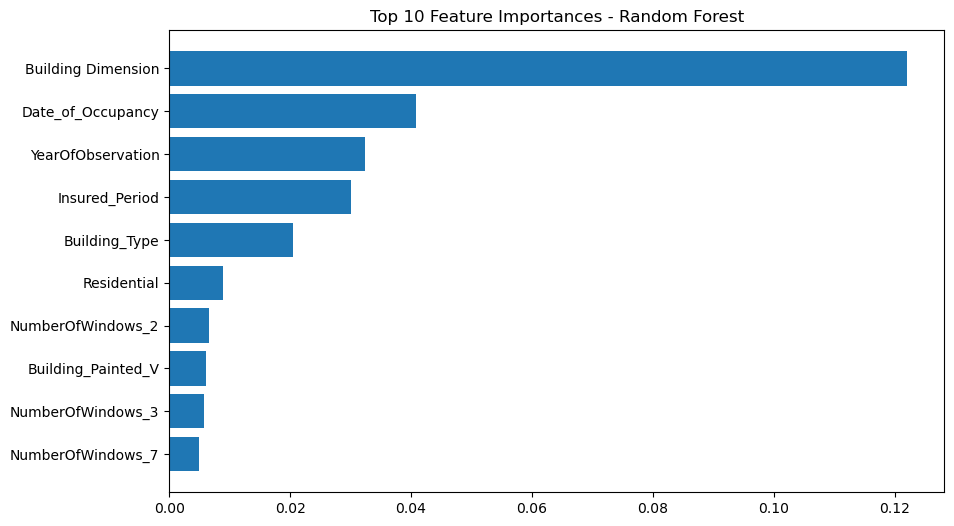

In [39]:
# Feature importance
importances = rf.feature_importances_
feature_names = x_train.columns

top_indices = np.argsort(importances)[-10:]
top_features = feature_names[top_indices]

plt.figure(figsize=(10,6))
plt.barh(top_features, importances[top_indices])
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

# **Insight:**
- Building dimension, building type,residential status and insured period are logical predictors. Larger or certain types of building are more likely to have claims.
- Date of occupancy and Year of observation may indicate aging buildings, which coluld affect risk.
- Window-related features have smaller importance but still contribute to prediction.

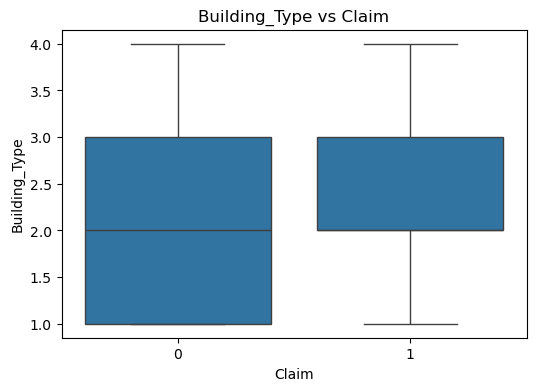

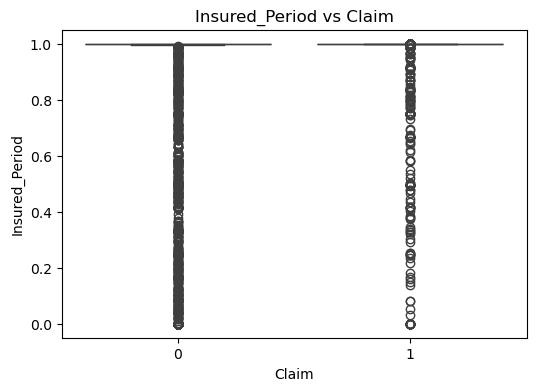

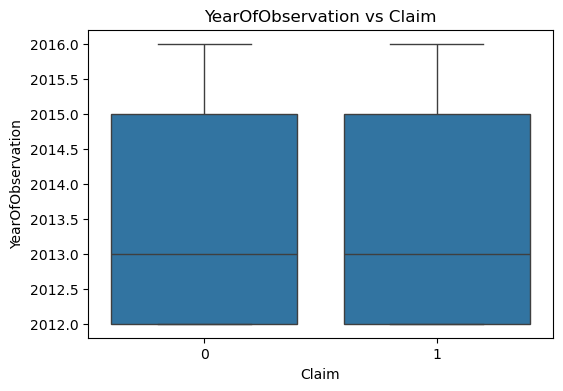

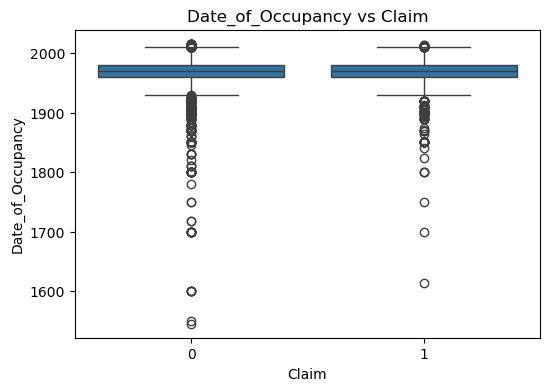

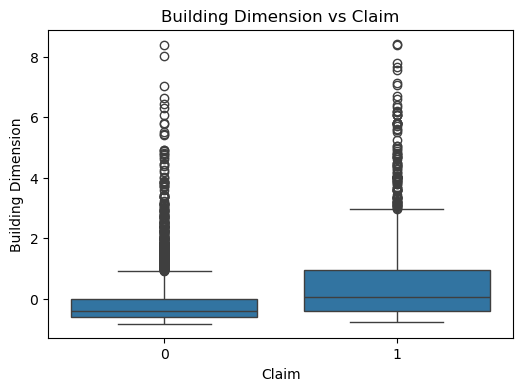

In [42]:
top_5_features = top_features[-5:]

for feature in top_5_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=y, y=x[feature])
    plt.title(f"{feature} vs Claim")
    plt.show()

# **Top 5 Features vs Claim:**
- Visualizes distribution differences for claim vs non-claim buildings.
- Helps identify which features vary most with the target.
- Supports features importance analysis.

# **Project Summary & Conclusion**

- **Objective:** Predict probability of insurance claims using building characteristics.
- **Data Cleaning & Preprocessing:** Removed missing values, encoded categorical features, selected numeric/boolean features.
- **EDA Insights:** Claim target is imbalanced; most numeric features are boolean; correlations with target are weak to moderate.
- **Modeling:**
  - Logistic Regression (baseline): ROC-AUC = {roc_auc_lr:.3f}
  - Random Forest: ROC-AUC = {roc_auc_rf:.3f}, better handling of non-linear relationships.
- **Feature Importance:** Top features include Building dimension, Date of occupancy, Year of observation, Insured period, Building type, and Residential.
- **Limitations:** Difficulty predicting rare claims due to imbalance and sparse features.
- **Next Steps / Improvements:**
  - Feature engineering (create meaningful aggregates)
  - Sampling techniques (SMOTE, undersampling)
  - Try boosting algorithms like XGBoost or LightGBM for better prediction